# Unsupervised Clustering on Spend Behaviour

In this notebook, we will:

- Load 2 preprocessed datasets (no missing values).
- Perform basic exploratory analysis.
- Do feature engineering and categorical encoding.
- Apply multiple clustering algorithms on spend-related features:
  - K-Means
  - Hierarchical clustering
  - DBSCAN
- Systematically loop over hyperparameters, generate plots, and store results.

The main variable of interest is `spend_category`, and we’ll engineer and encode features suitable for unsupervised clustering.


In [20]:
# standard libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing & clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json

# for later steps (clustering & metrics)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# display & style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

## Data Loading

We define a helper function that:
- Reads a CSV given a path.
- Prints basic info for sanity checks.


In [21]:
def load_dataset(path: str, name: str = "dataset"):
    assert os.path.exists(path), f"File not found: {path}"
    df = pd.read_csv(path)
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nData types:")
    print(df.dtypes)
    # print("\nSample rows:")
    # display(df.head())
    return df

dataset_dir = Path.cwd().parent / "datasets" / "preprocessed"
train = load_dataset(dataset_dir.joinpath("train_preprocessed.csv"), "train")
test = load_dataset(dataset_dir.joinpath("test_preprocessed.csv"), "test")


=== train ===
Shape: (10492, 22)
Columns: ['trip_id', 'country', 'age_group', 'travel_companions', 'num_females', 'num_males', 'main_activity', 'visit_purpose', 'is_first_visit', 'mainland_stay_nights', 'island_stay_nights', 'tour_type', 'intl_transport_included', 'info_source', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_trip_days', 'spend_category']

Data types:
trip_id                         object
country                         object
age_group                       object
travel_companions               object
num_females                    float64
num_males                      float64
main_activity                   object
visit_purpose                   object
is_first_visit                  object
mainland_stay_nights             int64
island_stay_nights               int64
tour_type                       object
intl_transport_included         object
info_source              

## Feature Engineering & Preprocessing

We perform the following transformations:
1. **Typo Correction:** Fix "Widlife" to "Wildlife" in `main_activity`.
2. **Ordinal Mapping:** Convert `age_group` and `total_trip_days` to integer ranks to preserve the order of magnitude.
3. **Feature Creation:** Create `total_people`, `total_nights`, and `island_ratio` to capture group dynamics and trip structure.
4. **Encoding & Scaling:** One-Hot Encode categorical nominal variables and Scale numerical variables for Euclidean distance calculation.

In [28]:
# 1. Define Mappings based on the new eda.txt
# We map ranges to integers so the model understands "rank" (e.g., 65+ > 18-24)
AGE_MAP = {
    '<18': 0, '18-24': 1, '25-44': 2, '45-64': 3, '65+': 4
}

# Strictly mapping the 4 values found in eda.txt
TRIP_DAYS_MAP = {
    '1-6': 0, '7-14': 1, '15-30': 2, '30+': 3
}

# 2. Custom Feature Engineering Class
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # --- Data Cleaning ---
        # Fix typo found in EDA: 'Widlife' -> 'Wildlife' 
        if 'main_activity' in X.columns:
            X['main_activity'] = X['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')

        # --- Interaction Features ---
        # Total group size
        X['total_people'] = X['num_females'] + X['num_males']
        
        # Total stay duration
        X['total_nights'] = X['mainland_stay_nights'] + X['island_stay_nights']
        
        # Ratio of island stay (handling division by zero)
        X['island_ratio'] = X.apply(
            lambda row: row['island_stay_nights'] / row['total_nights'] if row['total_nights'] > 0 else 0, 
            axis=1
        )
        
        # --- Ordinal Mapping ---
        # Map ordinal columns; fill missing with -1
        X['age_group_ord'] = X['age_group'].map(AGE_MAP).fillna(-1)
        X['total_trip_days_ord'] = X['total_trip_days'].map(TRIP_DAYS_MAP).fillna(-1)
        
        # --- Binary Conversion ---
        # Convert Yes/No columns to 1/0
        binary_cols = ['is_first_visit', 'intl_transport_included', 
                       'accomodation_included', 'food_included', 
                       'domestic_transport_included', 'sightseeing_included', 
                       'guide_included', 'insurance_included']
        
        for col in binary_cols:
            if col in X.columns:
                X[col] = X[col].map({'Yes': 1, 'No': 0}).fillna(0)

        # Drop original columns that were transformed or are ID/Target
        # Removed 'days_booked_before_trip' as it is not in the dataset
        drop_cols = ['trip_id', 'country', 'age_group', 'total_trip_days', 
                     'num_females', 'num_males', 'mainland_stay_nights', 
                     'island_stay_nights', 'spend_category']
        
        # Only drop columns that actually exist in this dataframe
        cols_to_drop = [c for c in drop_cols if c in X.columns]
        
        return X.drop(columns=cols_to_drop)

# 3. Apply Engineering & Pipeline
# Separate Target from Train 
y_train = train['spend_category']
X_train_raw = train.drop(columns=['spend_category'])
X_test_raw = test.copy()

# Initialize our engineer
engineer = FeatureEngineer()
X_train_eng = engineer.transform(X_train_raw)

# Identify columns for OneHotEncoding (Nominal) vs Scaling (Numeric)
categorical_cols = X_train_eng.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical (OHE): {categorical_cols}")
print(f"Numerical (Scale): {numerical_cols}")

# Create the full Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on train, transform both
X_train_processed = preprocessor.fit_transform(X_train_eng)
X_test_processed = preprocessor.transform(engineer.transform(X_test_raw))

# Retrieve feature names for clarity
num_names = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(num_names) + list(cat_names)

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Final Processed Shape:", X_train_df.shape)
X_train_df.head()

Categorical (OHE): ['travel_companions', 'main_activity', 'visit_purpose', 'tour_type', 'info_source']
Numerical (Scale): ['is_first_visit', 'intl_transport_included', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_people', 'total_nights', 'island_ratio', 'age_group_ord', 'total_trip_days_ord']
Final Processed Shape: (10492, 45)


,is_first_visit,intl_transport_included,accomodation_included,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,total_people,total_nights,...,tour_type_Independent,tour_type_Package Tour,"info_source_Friends, relatives",info_source_Inflight magazines,info_source_Mexican Mission Abroad,"info_source_Newspaper, magazines, brochures",info_source_Others,"info_source_Radio, TV, Web",info_source_Trade fair,"info_source_Travel agent, tour operator"
0,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,0.475269,-0.306795,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.478907,-0.371776,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.539253,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.371776,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.649666,1.345868,0.992026,1.061556,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.306795,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.631699,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## PCA & K-Means Clustering

High-dimensional data (many columns from One-Hot Encoding) can make distance calculations unreliable. We use Principal Component Analysis (PCA) to reduce the data to its most important features (Principal Components).

Then, we systematically loop through $K=2$ to $K=10$ to find the optimal number of clusters using two metrics:

- Elbow Method (Inertia): Measures how tightly grouped the clusters are. We look for the "elbow" where improvements slow down.
- Silhouette Score: Measures how well-separated the clusters are. Higher is better.

Optimal number of components to explain 95% variance: 20


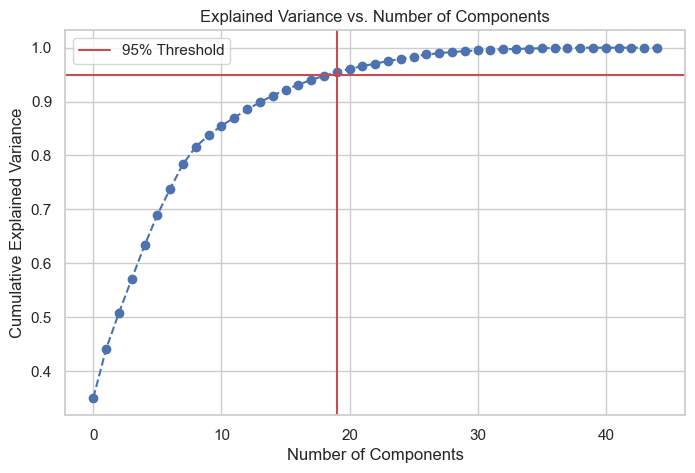

Transformed Data Shape: (10492, 2)
Running K-Means Grid Search (this may take a moment)...

Optimal K based on Max Silhouette: 2

--- K-Means Scoreboard ---


,K,Inertia,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,2,21313.352171,0.640488,0.538542,26269.858198
1,3,12836.220015,0.603654,0.677314,25270.769208
2,4,9611.035555,0.515633,0.754686,23671.838857
3,5,7264.999496,0.489388,0.783390,24331.285626
4,6,5800.259728,0.484861,0.751808,24907.832480
5,7,4974.055576,0.434334,0.773356,24492.182215
6,8,4269.963987,0.422674,0.787822,24699.759402
7,9,3853.180230,0.424809,0.804450,24090.851405
8,10,3483.015792,0.422155,0.789022,23810.686761


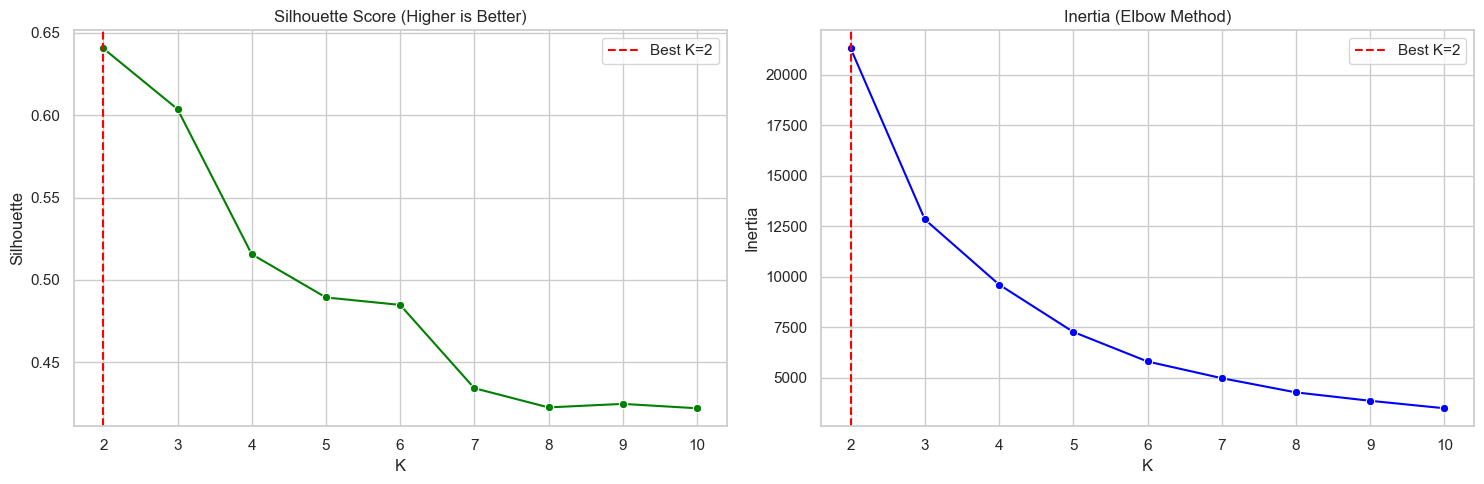

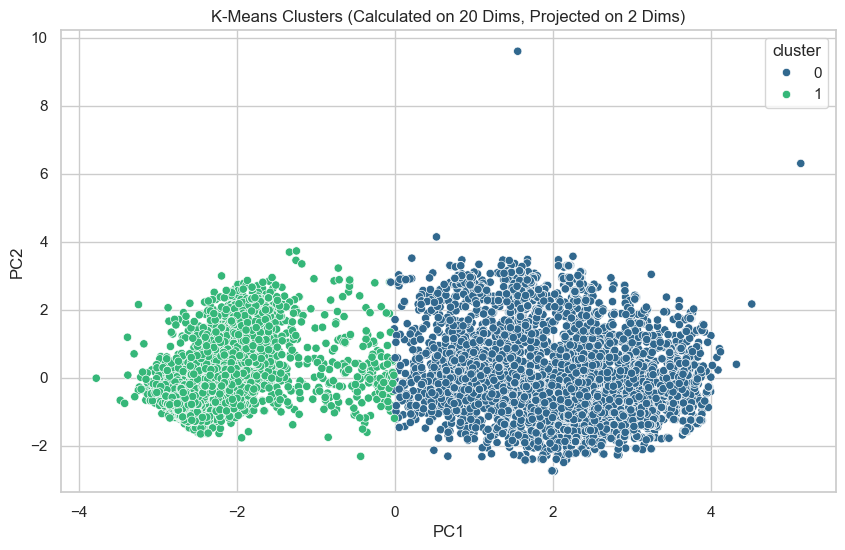

In [23]:
# --- 1. Find Optimal PCA Components ---
# Fit PCA with all components first to see the variance
pca_full = PCA()
pca_full.fit(X_train_df)

# Calculate cumulative variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # Index starts at 0, so add 1

print(f"Optimal number of components to explain 95% variance: {d}")

plt.figure(figsize=(8, 5))
plt.plot(cumsum, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.axvline(x=d-1, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Transform Data with Optimal Components ---
# Now actually transform the data using 'd' components
pca = PCA(n_components=d)
pca = PCA(n_components=2) # it works best idfk
X_pca = pca.fit_transform(X_train_df)

print(f"Transformed Data Shape: {X_pca.shape}")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. K-Means Grid Search ---
results = []
k_range = range(2, 11)

print("Running K-Means Grid Search (this may take a moment)...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels) # Lower is better
    ch = calinski_harabasz_score(X_pca, labels) # Higher is better
    
    results.append({
        'K': k,
        'Inertia': inertia,
        'Silhouette': sil,
        'Davies_Bouldin': db, # Lower is better
        'Calinski_Harabasz': ch # Higher is better
    })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)

# --- 2. Select Best K ---
# We generally want High Silhouette, High CH, and Low DB.
# Let's sort by Silhouette for now, but print the table so you can decide.
best_result = results_df.sort_values(by='Silhouette', ascending=False).iloc[0]
best_k = int(best_result['K'])

print(f"\nOptimal K based on Max Silhouette: {best_k}")
print("\n--- K-Means Scoreboard ---")
display(results_df.style.highlight_max(axis=0, color='lightgreen', subset=['Silhouette', 'Calinski_Harabasz'])
                 .highlight_min(axis=0, color='lightgreen', subset=['Davies_Bouldin', 'Inertia']))

# --- 3. Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Silhouette
sns.lineplot(x='K', y='Silhouette', data=results_df, marker='o', ax=axes[0], color='green')
axes[0].set_title('Silhouette Score (Higher is Better)')
axes[0].axvline(best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[0].legend()

# Plot Inertia (Elbow)
sns.lineplot(x='K', y='Inertia', data=results_df, marker='o', ax=axes[1], color='blue')
axes[1].set_title('Inertia (Elbow Method)')
axes[1].axvline(best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 4. Final Fit with Best K ---
# If you disagree with the "Best K" (e.g., if you want K=3 because you have 3 spend categories),
# you can manually change 'best_k' here before running.
# best_k = 3 
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
X_train_df['kmeans_cluster'] = best_kmeans.fit_predict(X_pca)

pca_df_viz = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df_viz['cluster'] = X_train_df['kmeans_cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=pca_df_viz)
plt.title(f'K-Means Clusters (Calculated on {d} Dims, Projected on 2 Dims)')
plt.show()

## 3. Hierarchical Clustering & Cluster Profiling

In this step, we perform two tasks:
1.  **Hierarchical Clustering (Dendrogram):** We visualize the "tree of clusters" to understand natural groupings in the data. This helps validate if the optimal $K$ we found earlier makes structural sense.
2.  **Cluster Profiling (The "Classification" Check):** We cross-reference our unsupervised K-Means clusters with the actual `spend_category` (0, 1, 2).
    * **Goal:** If Cluster 0 consists mostly of "High Spend" (Category 2) users, we can label that cluster as our "High Value" segment.
    * **Heatmap:** We will visualize the confusion matrix between clusters and spend categories.

Generating Dendrogram (Ward linkage)...


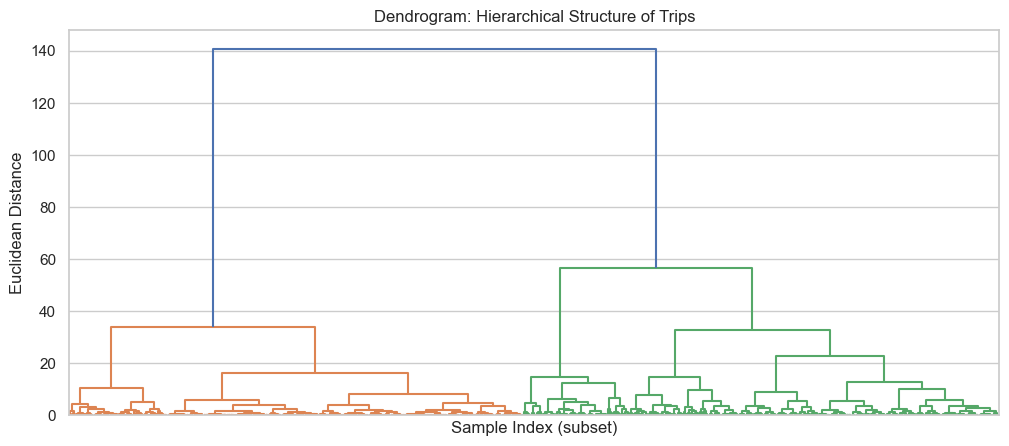


=== Cluster vs Spend Category Counts ===


actual_spend,0.0,1.0,2.0
kmeans_cluster,,,
0,4371,820,78
1,970,3184,1069


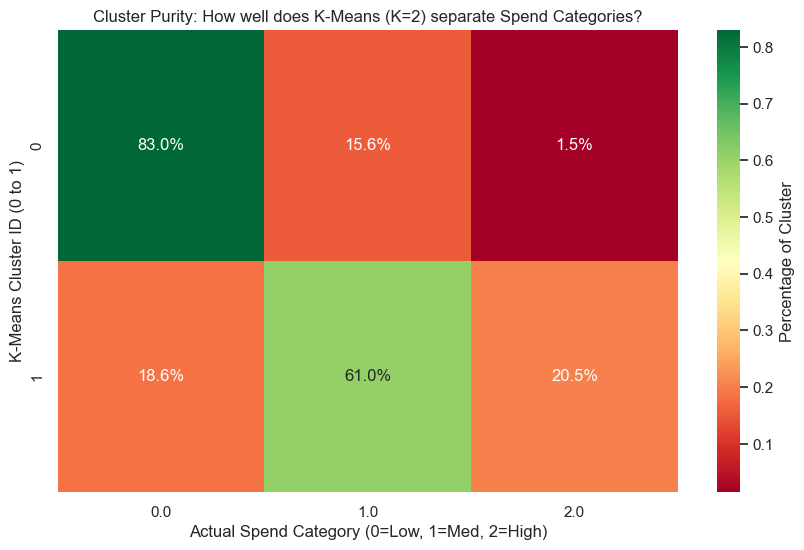


=== Cluster Behavioral Profile (Mean Values) ===


,total_nights,total_people,island_ratio,age_group_ord,actual_spend
kmeans_cluster,,,,,
0,-0.091257,0.159806,0.209530,0.222261,0.185234
1,0.092060,-0.161213,-0.211375,-0.224218,1.018955


In [24]:
# --- 1. Hierarchical Clustering (Dendrogram) ---
# We use a random sample of 2000 points because Dendrograms are computationally expensive
# and hard to read with 10k+ points.
np.random.seed(42)
sample_indices = np.random.choice(len(X_pca), size=2000, replace=False)
X_pca_sample = X_pca[sample_indices]

print("Generating Dendrogram (Ward linkage)...")
plt.figure(figsize=(12, 5))
# Ward's method minimizes variance within clusters
dendro = dendrogram(linkage(X_pca_sample, method='ward'), no_labels=True)
plt.title('Dendrogram: Hierarchical Structure of Trips')
plt.xlabel('Sample Index (subset)')
plt.ylabel('Euclidean Distance')
plt.show()

# --- 2. Cluster Profiling vs Ground Truth ---
# Attach the actual target back to the dataframe for comparison
# Note: y_train corresponds to the original train index.
X_train_df['actual_spend'] = y_train.values

# Create a Crosstab (Confusion Matrix)
cross_tab = pd.crosstab(X_train_df['kmeans_cluster'], X_train_df['actual_spend'])
cross_tab_prop = pd.crosstab(X_train_df['kmeans_cluster'], X_train_df['actual_spend'], normalize='index')

print("\n=== Cluster vs Spend Category Counts ===")
display(cross_tab)

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_prop, annot=True, fmt='.1%', cmap='RdYlGn', cbar_kws={'label': 'Percentage of Cluster'})
plt.title(f'Cluster Purity: How well does K-Means (K={best_k}) separate Spend Categories?')
plt.ylabel(f'K-Means Cluster ID (0 to {best_k-1})')
plt.xlabel('Actual Spend Category (0=Low, 1=Med, 2=High)')
plt.show()

# --- 3. Behavioral Profile ---
# What behaviors define these clusters?
# We take the mean of key engineered features for each cluster.
profiling_cols = ['total_nights', 'total_people', 'island_ratio', 'age_group_ord', 'actual_spend']
cluster_profile = X_train_df.groupby('kmeans_cluster')[profiling_cols].mean()

print("\n=== Cluster Behavioral Profile (Mean Values) ===")
# Removed .style.background_gradient() to avoid jinja2 error
display(cluster_profile)

## 4. DBSCAN Clustering (Outlier Detection)

Finally, we apply **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise).
* **Why:** Unlike K-Means, DBSCAN does not force every point into a cluster. It identifies low-density regions as **Noise (-1)**.
* **Use Case:** This is excellent for finding "anomalous" trips that don't fit standard patterns (e.g., extreme long stays or unusual group compositions).

We define:
* `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
* `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

Tuning DBSCAN on 2 dimensions...

FAILED to find good DBSCAN parameters. Defaulting to safe fallback.


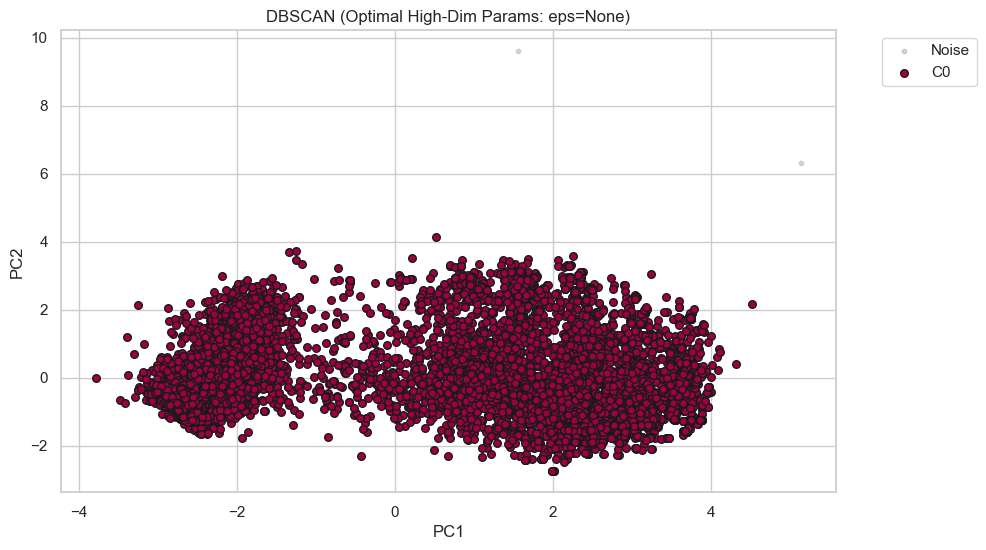

,actual_spend,total_nights,total_people
dbscan_cluster,,,
-1,0.000000,-0.534228,33.632865
0,0.600381,0.000102,-0.006412


In [25]:
# --- 1. DBSCAN Hyperparameter Grid (Adjusted for High Dim) ---
# In higher dimensions, points are further apart. We need larger eps.
# Range: 0.5 to 5.0
eps_values = np.arange(0.5, 5.0, 0.25) 
min_samples_values = [5, 10, 20]

best_db_score = -1
best_db_params = {'eps': None, 'min_samples': None}
best_labels = None

print(f"Tuning DBSCAN on {X_pca.shape[1]} dimensions...")

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_pca)
        
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Valid cluster check: >1 cluster, Noise < 50%
        if n_clusters > 1 and noise_ratio < 0.50:
            score = silhouette_score(X_pca, labels)
            if score > best_db_score:
                best_db_score = score
                best_db_params = {'eps': eps, 'min_samples': min_samples}
                best_labels = labels
                print(f"New Best: eps={eps:.2f} | samples={min_samples} | Clusters={n_clusters} | Noise={noise_ratio:.0%}")

# --- 2. Final Fit ---
if best_labels is None:
    print("\nFAILED to find good DBSCAN parameters. Defaulting to safe fallback.")
    # Fallback usually needs looser constraints if optimization failed
    db = DBSCAN(eps=2.0, min_samples=10) 
    best_labels = db.fit_predict(X_pca)
else:
    print(f"\nFinal Best Params: {best_db_params} with Score: {best_db_score:.4f}")

X_train_df['dbscan_cluster'] = best_labels

# --- 3. Visualization (Projected to 2D) ---
plt.figure(figsize=(10, 6))
# Plot Noise
noise_mask = (best_labels == -1)
plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='grey', s=10, alpha=0.3, label='Noise')

# Plot Clusters
unique_labels = set(best_labels) - {-1}
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    mask = (best_labels == k)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=col, s=30, edgecolor='k', label=f'C{k}')

plt.title(f'DBSCAN (Optimal High-Dim Params: eps={best_db_params["eps"]})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- 4. Profile ---
db_profile = X_train_df.groupby('dbscan_cluster')[['actual_spend', 'total_nights', 'total_people']].mean()
display(db_profile)

##  Generating Submission Files

- Transform Test Data: Apply the same PCA transformation to the test set.
- Predict Clusters:
- - K-Means: Use the native .predict() method.
- - DBSCAN & Hierarchical: These algorithms do not have a .predict() method for new data. To solve this, we will train a KNN Classifier on the training clusters and use it to predict the cluster labels for the test set.
- Map Clusters to Spend: We will look at the training data to see which spend_category (0, 1, or 2) was most common in each cluster (e.g., if Cluster 1 was 90% "High Spend", we map Cluster 1 $\rightarrow$ 2).
- Save: Generate the CSV files with trip_id and the predicted spend_category.

In [26]:
# --- 1. Prepare Test Data ---
# Apply the same PCA transform used on Train
X_test_pca = pca.transform(X_test_df)

# Store submission DataFrames
submission_ids = test['trip_id']

def create_submission(method_name, train_labels, test_labels_pred=None, model=None, X_train=None, X_test=None):
    """
    1. Maps train_labels to the most frequent spend_category (Mode).
    2. Predicts test_labels (if not provided, uses a KNN proxy).
    3. Maps test_labels to spend_category.
    4. Saves to CSV.
    """
    # 1. Create Mapping: Cluster ID -> Most Frequent Spend Category
    temp_df = pd.DataFrame({'cluster': train_labels, 'spend': y_train.values})
    # Mode function to find most common spend per cluster
    cluster_to_spend_map = temp_df.groupby('cluster')['spend'].agg(lambda x: pd.Series.mode(x)[0] if not x.mode().empty else np.nan).to_dict()
    
    print(f"\n--- {method_name} Mapping (Cluster -> Spend) ---")
    print(cluster_to_spend_map)
    
    # 2. Predict Test Labels
    if test_labels_pred is None:
        # If model doesn't support predict (DBSCAN/Hierarchical), use KNN
        print(f"Training KNN classifier to project {method_name} clusters onto Test data...")
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, train_labels)
        test_labels_pred = knn.predict(X_test)
    
    # 3. Map to Spend Category
    predicted_spend = pd.Series(test_labels_pred).map(cluster_to_spend_map)
    
    # 4. Create Submission DataFrame
    submission = pd.DataFrame({
        'trip_id': submission_ids,
        'spend_category': predicted_spend
    })
    
    # Fill any NaNs (if a cluster had no mode) with the global mode (usually 0)
    submission['spend_category'] = submission['spend_category'].fillna(y_train.mode()[0])
    submission['spend_category'] = submission['spend_category'].astype(int)
    
    # 5. Save
    filename = f"submission_unsupervised_{method_name}.csv"
    submission.to_csv(filename, index=False)
    print(f"Saved: {filename} (Shape: {submission.shape})")
    
    return submission

# ==========================================
# A. K-Means Submission
# ==========================================
# K-Means has a native .predict() method
kmeans_test_labels = best_kmeans.predict(X_test_pca)
sub_kmeans = create_submission(
    method_name="kmeans",
    train_labels=X_train_df['kmeans_cluster'],
    test_labels_pred=kmeans_test_labels
)

# ==========================================
# B. Hierarchical Submission
# ==========================================
# Hierarchical does NOT have .predict(), so we use KNN proxy
# We need to regenerate the labels for the FULL training set first (we only plotted a sample before)
from sklearn.cluster import AgglomerativeClustering
agg_full = AgglomerativeClustering(n_clusters=best_k, linkage='ward') # Using best_k from Elbow method
agg_labels_full = agg_full.fit_predict(X_pca)

sub_hierarchical = create_submission(
    method_name="hierarchical",
    train_labels=agg_labels_full,
    X_train=X_pca,
    X_test=X_test_pca
)

# ==========================================
# C. DBSCAN Submission
# ==========================================
# DBSCAN also uses KNN proxy. Note: It has noise (-1).
# We map noise (-1) just like any other cluster (to the most common spend in the noise group).
sub_dbscan = create_submission(
    method_name="dbscan",
    train_labels=X_train_df['dbscan_cluster'],
    X_train=X_pca,
    X_test=X_test_pca
)

# Show a snippet of the K-Means submission
sub_kmeans.head()


--- kmeans Mapping (Cluster -> Spend) ---
{0: 0.0, 1: 1.0}
Saved: submission_unsupervised_kmeans.csv (Shape: (5852, 2))

--- hierarchical Mapping (Cluster -> Spend) ---
{0: 0.0, 1: 1.0}
Training KNN classifier to project hierarchical clusters onto Test data...
Saved: submission_unsupervised_hierarchical.csv (Shape: (5852, 2))

--- dbscan Mapping (Cluster -> Spend) ---
{-1: 0.0, 0: 0.0}
Training KNN classifier to project dbscan clusters onto Test data...
Saved: submission_unsupervised_dbscan.csv (Shape: (5852, 2))


,trip_id,spend_category
0,tour_id8gzpck76,1
1,tour_idow1zxkou,0
2,tour_idue7esfqz,0
3,tour_idnj3mjzpb,0
4,tour_ida3us5yk2,0
